# [Assignment 3 - Data Analytics in Action](https://canvas.uts.edu.au/courses/30539/assignments/172296)

In [57]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
DATAFILE = "./dataGaia_AB_train.csv"
gaia = pd.read_csv(DATAFILE)

In [59]:
# Converts SpType-ELS labels to to {'A': 0, 'B':1}
get_label =  lambda x: 0 if re.match("[AB]", x)[0] == "A" else 1
gaia["SpType-ELS"] = gaia["SpType-ELS"].apply(get_label)

In [71]:
data = gaia.drop(["Unnamed: 0"], axis=1)

### Feature Engineering
Create feature labelling attributes that originally contained a value compared to those that didn't

In [67]:
# These null features aren't indicative of A and B labels however, their missing values appear to only be B values
null_features = ["GRVSmag", "e_GRVSmag", "Lum-Flame", "Mass-Flame", "Age-Flame", "z-Flame", "pscol"]

# Hence, we create new features to show which features were originally null or not
for feature in null_features:
    data[f"{feature} isnull"] = data[feature].isnull().astype(int)

### Feature Selection
- ID
- GRVSmag isnull
- e_GRVSmag isnull
- Lum-Flame isnull
- Mass-Flame isnull
- Age-Flame isnull
- z-Flame isnull
- Teff
- Dist

Source
Mass-Flame
RA_ICRS
Gmag
BPmag
RPmag
Lum-Flame
Age-Flame


In [8]:
# Lum-Flame = 2995
# Mass-Flame = 12551
# Age-Flame = 38016
# z-Flame = 2995

# The status of Age-Flame having a value is dependent on both Lum-Flame, and Mass-Flame having a value.
# Hence it is redundant to use all flame values

print("Entries where Lum-Flame is null and z-Flame is not null:", len(data[(data["Lum-Flame isnull"]==1) & (data["z-Flame isnull"]==0)]))
print("Entries where Lum-Flame is not null and z-Flame is null:", len(data[(data["Lum-Flame isnull"]==0) & (data["z-Flame isnull"]==1)]))
print("Entries where Lum-Flame is null and Mass-Flame is not null:", len(data[(data["Lum-Flame isnull"]==1) & (data["Mass-Flame isnull"]==0)]))
print("Entries where Lum-Flame is not null and Mass-Flame is null:", len(data[(data["Lum-Flame isnull"]==0) & (data["Mass-Flame isnull"]==1)]))
print("Entries where Mass-Flame is null and Age-Flame is not null:", len(data[(data["Mass-Flame isnull"]==1) & (data["Age-Flame isnull"]==0)]))
print("Entries where Mass-Flame is not null and Age-Flame is null:", len(data[(data["Mass-Flame isnull"]==0) & (data["Age-Flame isnull"]==1)]))

Entries where Lum-Flame is null and z-Flame is not null: 0
Entries where Lum-Flame is not null and z-Flame is null: 0
Entries where Lum-Flame is null and Mass-Flame is not null: 0
Entries where Lum-Flame is not null and Mass-Flame is null: 9556
Entries where Mass-Flame is null and Age-Flame is not null: 0
Entries where Mass-Flame is not null and Age-Flame is null: 25465


Both GRVSmag and e_GRVSmag share the same null entries. Thus, one of them can be removed from feature selection.

In [62]:
data[pd.isnull(data["GRVSmag"])]["ID"]

80090     100002
80091     100003
80092     100004
80093     100005
80099     100014
           ...  
148531    185665
148532    185666
148533    185667
148536    185671
148537    185672
Name: ID, Length: 64054, dtype: int64

In [63]:
data[pd.isnull(data["e_GRVSmag"])]["ID"]

80090     100002
80091     100003
80092     100004
80093     100005
80099     100014
           ...  
148531    185665
148532    185666
148533    185667
148536    185671
148537    185672
Name: ID, Length: 64054, dtype: int64

Impute null values of features with the median.

In [68]:
for feature in null_features:
    median = data.groupby("SpType-ELS")[feature].transform("median")
    data[feature] = data[feature].fillna(median)

### Feature Selection
These are the features that will be used for model training. Only relevant features are used in the training set.

In [69]:
# Null and highly correlated features
features = ["ID", 
            "GRVSmag isnull", 
            "e_GRVSmag isnull", 
            "Lum-Flame isnull",
            "z-Flame isnull",
            "Mass-Flame isnull",
            "Age-Flame isnull",
            "pscol isnull",
            "Teff", 
            "Dist", 
            "Source", 
            "SpType-ELS"]
train_set = pd.DataFrame()

for feature in features:
    train_set[feature] = data[feature]

ID                   0.863172
Unnamed: 0          -0.131111
GRVSmag isnull       0.941852
e_GRVSmag isnull     0.941852
Lum-Flame isnull     0.155167
z-Flame isnull       0.155167
Mass-Flame isnull    0.328615
Age-Flame isnull     0.634389
pscol isnull         0.169904
Teff                 0.703806
Dist                 0.599478
Source              -0.625606
SpType-ELS           1.000000
Name: SpType-ELS, dtype: float64


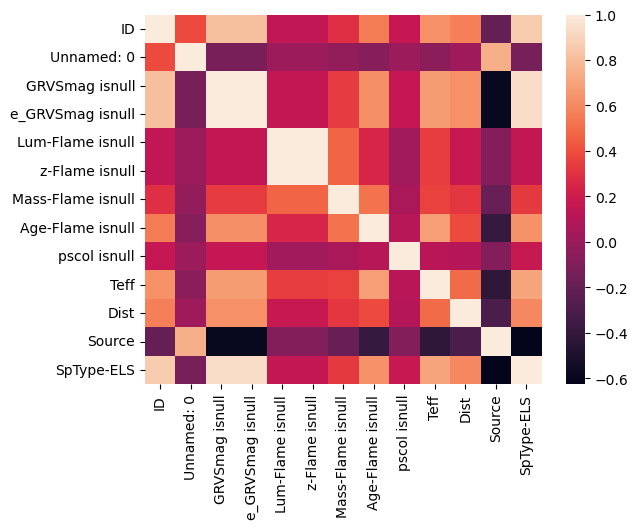

In [70]:
# See correlations between features
matrix = train_set.corr(method="pearson")
sns.heatmap(matrix, annot=False)
print(matrix["SpType-ELS"])

In [11]:
# These are the features that seem most indicative of SpType-ELS
features = ["ID", 
            "GRVSmag isnull", 
            "Age-Flame isnull",
            "Teff", 
            "Dist", 
            "Source", 
            "SpType-ELS"]
train_set = pd.DataFrame()

for feature in features:
    train_set[feature] = data[feature]

### Feature Normalization
Convert to 0-1 scale sigmoid
- Teff
- Dist
- ID
- Source

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
sigmoid = lambda x: 1/(1+np.exp(-x))

In [14]:
scaler = StandardScaler()
normalized = scaler.fit_transform(train_set[["Teff"]])
train_set["Teff"] = pd.DataFrame(normalized).apply(sigmoid)

In [15]:
scaler = StandardScaler()
normalized = scaler.fit_transform(train_set[["Dist"]])
train_set["Dist"] = pd.DataFrame(normalized).apply(sigmoid)

In [16]:
scaler = StandardScaler()
normalized = scaler.fit_transform(train_set[["ID"]])
train_set["ID"] = pd.DataFrame(normalized).apply(sigmoid)

In [17]:
scaler = StandardScaler()
normalized = scaler.fit_transform(train_set[["Source"]])
train_set["Source"] = pd.DataFrame(normalized).apply(sigmoid)

In [158]:
def z_score(data:pd.DataFrame):
    mean = data.mean()
    std_dev = data.std()

    return (data - mean)/std_dev

def min_max(data:pd.DataFrame):
    data_min = np.min(data)
    data_max = np.max(data)
    return (data-data_min)/(data_max-data_min)

In [166]:
data_feat["ID"] = min_max(data_feat["ID"])
data_feat["Teff"] = min_max(data_feat["Teff"])
data_feat["Dist"] = min_max(data_feat["Dist"])

ID                  0.880253
GRVSmag isnull      0.941852
Age-Flame isnull    0.634389
Teff                0.804017
Dist                0.726810
Source             -0.634606
SpType-ELS          1.000000
Name: SpType-ELS, dtype: float64


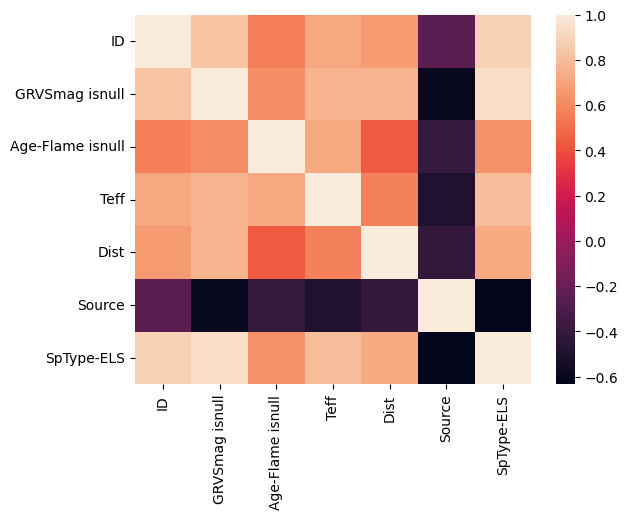

In [18]:
# See correlations between features
matrix = train_set.corr(method="pearson")
sns.heatmap(matrix, annot=False)
print(matrix["SpType-ELS"])

### Model Training
I want to first test out the most obvious features that we have available. If the model doesn't perform that well then we can consider adding more features an doing some additional data reduction.

**Models:**
- Decision Tree
- KNN
- Neural Networks
- SVM
- Random Forest

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [20]:
X = train_set.iloc[:, :-1]  # Features to train the model
y = train_set.iloc[:, -1]   # Target feature to be predicted

In [32]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
nn = MLPClassifier(hidden_layer_sizes=10, activation="logistic", learning_rate_init=0.001)       # sigmoid activation function
svc = SVC(kernel="poly", probability=True)
rf = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2)

# Define the k-fold cross-validation method
k = 5   # number of folds
kf = KFold(n_splits=k, random_state=None, shuffle=True)

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23886
           1       1.00      1.00      1.00     20676

    accuracy                           1.00     44562
   macro avg       1.00      1.00      1.00     44562
weighted avg       1.00      1.00      1.00     44562



In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000


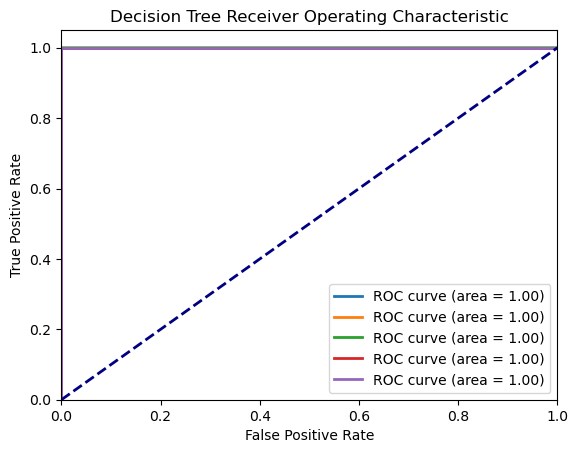

In [24]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    y_probs = dt.predict_proba(X_test)
    y_probs_B = y_probs[:,1]

    auc = roc_auc_score(y_test, y_probs_B)
    print('The AUC is {:.3f}'.format(auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_B, pos_label=1)
    print("Threshold\tTPR vs FPR")
    for f, p, t in zip(fpr, tpr, thresholds):
        print("{:.3f}\t{:.3f} vs {:.3f}".format(t, p, f))

    # cm = confusion_matrix(y_test, y_pred)
    # display = ConfusionMatrixDisplay(cm)
    # display.plot()

    # plt.figure()
    lw = 2 # the line width
    plt.plot(fpr, tpr,
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC is 1.000
Threshold	TPR vs FPR
inf	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
inf	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
inf	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
inf	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
inf	0.000 vs 0.000
1.000	1.000 vs 0.000
0.000	1.000 vs 1.000


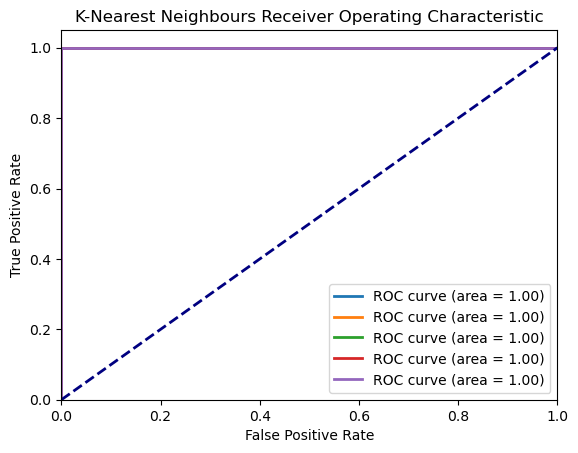

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_probs = knn.predict_proba(X_test)
    y_probs_B = y_probs[:,1]

    auc = roc_auc_score(y_test, y_probs_B)
    print('The AUC is {:.3f}'.format(auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_B, pos_label=1)
    print("Threshold\tTPR vs FPR")
    for f, p, t in zip(fpr, tpr, thresholds):
        print("{:.3f}\t{:.3f} vs {:.3f}".format(t, p, f))

    # cm = confusion_matrix(y_test, y_pred)
    # display = ConfusionMatrixDisplay(cm)
    # display.plot()

    # plt.figure()
    lw = 2 # the line width
    plt.plot(fpr, tpr,
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbours Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.000 vs 0.000
0.991	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.000 vs 0.000
0.991	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.000 vs 0.000
0.994	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.000 vs 0.000
0.994	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.000 vs 0.000
0.992	1.000 vs 0.000
0.000	1.000 vs 1.000


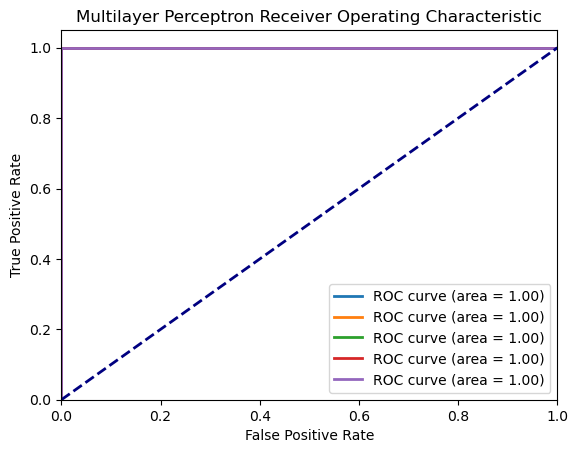

In [73]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    y_probs = nn.predict_proba(X_test)
    y_probs_B = y_probs[:,1]

    auc = roc_auc_score(y_test, y_probs_B)
    print('The AUC is {:.3f}'.format(auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_B, pos_label=1)
    print("Threshold\tTPR vs FPR")
    for f, p, t in zip(fpr, tpr, thresholds):
        print("{:.3f}\t{:.3f} vs {:.3f}".format(t, p, f))

    # cm = confusion_matrix(y_test, y_pred)
    # display = ConfusionMatrixDisplay(cm)
    # display.plot()

    # plt.figure()
    lw = 2 # the line width
    plt.plot(fpr, tpr,
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multilayer Perceptron Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.773 vs 0.000
1.000	0.773 vs 0.000
1.000	0.773 vs 0.000
1.000	0.774 vs 0.000
1.000	0.774 vs 0.000
1.000	0.774 vs 0.000
1.000	0.775 vs 0.000
1.000	0.775 vs 0.000
1.000	0.775 vs 0.000
1.000	0.775 vs 0.000
1.000	0.775 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.776 vs 0.000
1.000	0.777 vs 0.000
1.000	0.777 vs 0.000
1.000	0.777 vs 0.000
1.000	0.777 vs 0.000
1.000	0.777 vs 0.000
1.000	0.777 vs 0.000
1.000	0.778 vs 0.000
1.000	0.778 vs 0.000
1.000	0.778 vs 0.000
1.000	0.778 vs 0.000
1.000	0.779 vs 0.000
1.000	0.779 vs 0.000
1.000	0.780 vs 0.000
1.000	0.780 vs 0.000
1.000	0.781 vs 0.000
1.000	0.781 vs 0.000
1.000	0.781 vs 0.000
1.000	0.781 vs 0.000
1.000	0.782 vs 0.000
1.000	0.782 vs 0.000
1.000	0.782 vs 0.000
1.000	0.783 vs 0.000
1.000	0.783 vs 0.000
1.000	0.783 vs 0.000
1.000	0.783 vs 0.000
1.000	0.783 vs 0.000
1.000	0.783 vs 0.

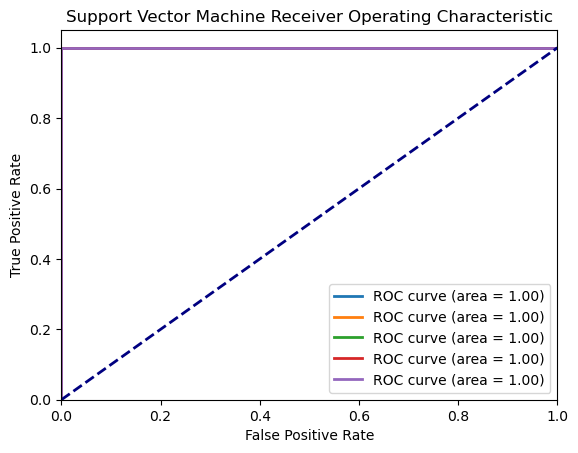

In [27]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_probs = svc.predict_proba(X_test)
    y_probs_B = y_probs[:,1]

    auc = roc_auc_score(y_test, y_probs_B)
    print('The AUC is {:.3f}'.format(auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_B, pos_label=1)
    print("Threshold\tTPR vs FPR")
    for f, p, t in zip(fpr, tpr, thresholds):
        print("{:.3f}\t{:.3f} vs {:.3f}".format(t, p, f))

    # cm = confusion_matrix(y_test, y_pred)
    # display = ConfusionMatrixDisplay(cm)
    # display.plot()

    # plt.figure()
    lw = 2 # the line width
    plt.plot(fpr, tpr,
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Machine Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.999 vs 0.000
0.967	1.000 vs 0.000
0.567	1.000 vs 0.000
0.033	1.000 vs 0.001
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	1.000 vs 0.000
0.867	1.000 vs 0.000
0.033	1.000 vs 0.000
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.999 vs 0.000
0.967	1.000 vs 0.000
0.933	1.000 vs 0.000
0.067	1.000 vs 0.000
0.033	1.000 vs 0.001
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.999 vs 0.000
0.967	1.000 vs 0.000
0.833	1.000 vs 0.000
0.100	1.000 vs 0.000
0.067	1.000 vs 0.000
0.033	1.000 vs 0.001
0.000	1.000 vs 1.000
The AUC is 1.000
Threshold	TPR vs FPR
2.000	0.000 vs 0.000
1.000	0.999 vs 0.000
0.967	1.000 vs 0.000
0.900	1.000 vs 0.000
0.067	1.000 vs 0.000
0.033	1.000 vs 0.001
0.000	1.000 vs 1.000


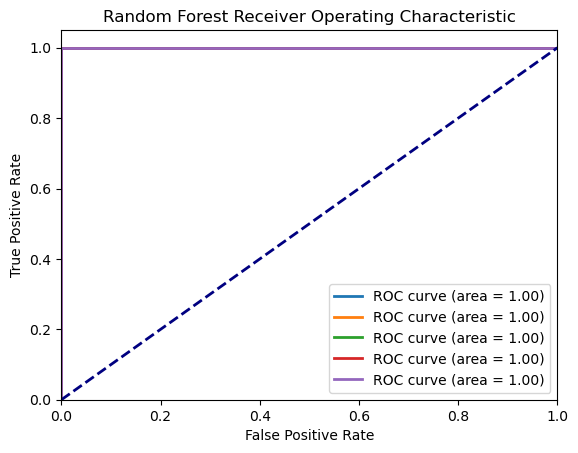

In [28]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_probs = rf.predict_proba(X_test)
    y_probs_B = y_probs[:,1]

    auc = roc_auc_score(y_test, y_probs_B)
    print('The AUC is {:.3f}'.format(auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_B, pos_label=1)
    print("Threshold\tTPR vs FPR")
    for f, p, t in zip(fpr, tpr, thresholds):
        print("{:.3f}\t{:.3f} vs {:.3f}".format(t, p, f))

    # cm = confusion_matrix(y_test, y_pred)
    # display = ConfusionMatrixDisplay(cm)
    # display.plot()

    # plt.figure()
    lw = 2 # the line width
    plt.plot(fpr, tpr,
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Retrain to get accuracy scores
dt_scores = cross_val_score(dt, X, y, scoring="accuracy", cv=kf)
dt_avg_score = dt_scores.mean()

knn_scores = cross_val_score(knn, X, y, scoring="accuracy", cv=kf)
knn_avg_score = knn_scores.mean()

nn_scores = cross_val_score(nn, X, y, scoring="accuracy", cv=kf)
nn_avg_score = nn_scores.mean()

svc_scores = cross_val_score(svc, X, y, scoring="accuracy", cv=kf)
svc_avg_score = svc_scores.mean()

rf_scores = cross_val_score(rf, X, y, scoring="accuracy", cv=kf)
rf_avg_score = rf_scores.mean()

##### Pass 1: Default parameters
```Python
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=2)
nn = MLPClassifier(hidden_layer_sizes=10, activation="logistic", learning_rate_init=0.001)
svc = SVC(kernel="rbf", probability=True)
rf = RandomForestClassifier(n_estimators=100)
```

> ```
> dt = [1.         0.99996634 1.         1.         1.        ]
> knn = [1. 1. 1. 1. 1.]
> nn = [1. 1. 1. 1. 1.]
> svc = [0.99993268 0.99996634 1.         0.99996634 0.99993268]
> rf = [1. 1. 1. 1. 1.]
> ```

##### Pass 2: Modified parameters
```Python
dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
nn = MLPClassifier(hidden_layer_sizes=10, activation="logistic", learning_rate_init=0.001)       # sigmoid activation function
svc = SVC(kernel="poly", probability=True)
rf = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2)
```

> ```
> dt = [1. 1. 1. 1. 1.]
> knn = [1. 1. 1. 1. 1.]
> nn = [1. 1. 1. 1. 1.]
> svc = [1. 1. 1. 1. 1.]
> rf = [1. 1. 1. 1. 1.]
> ```

In [35]:
print(dt_scores)
print(knn_scores)
print(nn_scores)
print(svc_scores)
print(rf_scores)

[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


In [36]:
print(dt_avg_score)
print(knn_avg_score)
print(nn_avg_score)
print(svc_avg_score)
print(rf_avg_score)

1.0
1.0
1.0
1.0
1.0


In [37]:
dt.fit(X, y)
knn.fit(X, y)
nn.fit(X, y)
svc.fit(X, y)
rf.fit(X, y)

RandomForestClassifier(n_estimators=30)

### Model Testing
Load and modify the features in the test set for prediction

In [38]:
# Load unlabelled test set
DATAFILE = "./dataGaia_AB_unknown.csv"
gaia_test = pd.read_csv(DATAFILE)

In [39]:
test = gaia_test.drop(["Unnamed: 0"], axis=1)

In [41]:
# These null features aren't indicative of A and B labels however, their missing values appear to only be B values
null_features = ["GRVSmag", "e_GRVSmag", "Lum-Flame", "Mass-Flame", "Age-Flame", "z-Flame", "pscol"]

# Hence, we create new features to show which features were originally null or not
for feature in null_features:
    test[f"{feature} isnull"] = test[feature].isnull().astype(int)

In [42]:
# Selecting the same features that were used with the training set
features = ["ID", 
            "GRVSmag isnull", 
            "Age-Flame isnull", 
            "Teff", 
            "Dist",
            "Source",]
test_feat = pd.DataFrame()

for feature in features:
    test_feat[feature] = test[feature]

##### Feature Normalization

In [43]:
scaler = StandardScaler()
normalized = scaler.fit_transform(test_feat[["ID"]])
test_feat["ID"] = pd.DataFrame(normalized).apply(sigmoid)

In [44]:
scaler = StandardScaler()
normalized = scaler.fit_transform(test_feat[["Teff"]])
test_feat["Teff"] = pd.DataFrame(normalized).apply(sigmoid)

In [45]:
scaler = StandardScaler()
normalized = scaler.fit_transform(test_feat[["Dist"]])
test_feat["Dist"] = pd.DataFrame(normalized).apply(sigmoid)

In [46]:
scaler = StandardScaler()
normalized = scaler.fit_transform(test_feat[["Source"]])
test_feat["Source"] = pd.DataFrame(normalized).apply(sigmoid)

##### Model Predictions
Each model makes a prediction on the unlabelled test set. Probabilities are also predicted for bagging ensembling.

In [48]:
dt_pred = dt.predict(test_feat)
knn_pred = knn.predict(test_feat)
nn_pred = nn.predict(test_feat)
svc_pred = svc.predict(test_feat)
rf_pred = rf.predict(test_feat)

In [49]:
dt_pred_proba = dt.predict_proba(test_feat)
knn_pred_proba = knn.predict_proba(test_feat)
nn_pred_proba = nn.predict_proba(test_feat)
svc_pred_proba = svc.predict_proba(test_feat)
rf_pred_proba = rf.predict_proba(test_feat)

In [50]:
# Bagging Ensembling
avg_probs = (knn_pred_proba + nn_pred_proba + svc_pred_proba + rf_pred_proba)/4
ensemble = np.argmax(avg_probs, axis=1)

In [51]:
dt_submission = pd.DataFrame()
dt_submission["ID"] = gaia_test["ID"]
dt_submission["SpType-ELS"] = pd.Series(dt_pred).replace({0:"A      ", 1:"B      "})
dt_submission.set_index("ID")

knn_submission = pd.DataFrame()
knn_submission["ID"] = gaia_test["ID"]
knn_submission["SpType-ELS"] = pd.Series(knn_pred).replace({0:"A      ", 1:"B      "})
knn_submission.set_index("ID")

nn_submission = pd.DataFrame()
nn_submission["ID"] = gaia_test["ID"]
nn_submission["SpType-ELS"] = pd.Series(nn_pred).replace({0:"A      ", 1:"B      "})
nn_submission.set_index("ID")

svc_submission = pd.DataFrame()
svc_submission["ID"] = gaia_test["ID"]
svc_submission["SpType-ELS"] = pd.Series(svc_pred).replace({0:"A      ", 1:"B      "})
svc_submission.set_index("ID")

rf_submission = pd.DataFrame()
rf_submission["ID"] = gaia_test["ID"]
rf_submission["SpType-ELS"] = pd.Series(rf_pred).replace({0:"A      ", 1:"B      "})
rf_submission.set_index("ID")

ens_submission = pd.DataFrame()
ens_submission["ID"] = gaia_test["ID"]
ens_submission["SpType-ELS"] = pd.Series(ensemble).replace({0:"A      ", 1:"B      "})

In [52]:
ens_submission["SpType-ELS"].describe()

count       37135
unique          2
top       A      
freq        19912
Name: SpType-ELS, dtype: object

In [54]:
dt_submission.to_csv("./submissions/dt_submission.csv", index=False)
knn_submission.to_csv("./submissions/knn_submission.csv", index=False)
nn_submission.to_csv("./submissions/nn_submission.csv", index=False)
svc_submission.to_csv("./submissions/svc_submission.csv", index=False)
rf_submission.to_csv("./submissions/rf_submission.csv", index=False)
ens_submission.to_csv("./submissions/ens_submission.csv", index=False)